In [71]:
import pandas as pd
import seaborn as sns

sns.set() 

import logging
import warnings

# Gensim
import gensim
import gensim.corpora as corpora

# Display setting to show more characters in column
pd.set_option('display.max_columns', 500)

from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

%matplotlib inline
warnings.filterwarnings("ignore",category=DeprecationWarning)
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

from nltk.corpus import stopwords

stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'not', 'would', 'say', 'could', '_', 'be', 'know', 'good', 'go', 'get', 'do', 'done', 'try', 'many', 'some', 'nice', 'thank', 'think', 'see', 'rather', 'easy', 'easily', 'lot', 'lack', 'make', 'want', 'seem', 'run', 'need', 'even', 'right', 'line', 'even', 'also', 'may', 'take', 'come', 'com', 'http', 'mail', 'pm'])

import pickle
import pyLDAvis
import pyLDAvis.gensim_models

### Load data

In [74]:
data_ready = pickle.load( open( "data/clean_words_sample.pickle", "rb" ) )

### LDA

In [75]:
# Create Dictionary
id2word = corpora.Dictionary(data_ready)

# Create Corpus: Term Document Frequency
corpus = [id2word.doc2bow(text) for text in data_ready]

# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(
    corpus=corpus,
    id2word=id2word,
    num_topics=5,
    random_state=100,
    update_every=1,
    chunksize=100,
    passes=60,
    alpha="auto",
    iterations=100,
    per_word_topics=True,
)

print(lda_model.print_topics())


[(0, '0.010*"amazon" + 0.009*"schedule" + 0.006*"message" + 0.006*"feedback" + 0.005*"order" + 0.005*"list" + 0.005*"offer" + 0.005*"final" + 0.005*"click" + 0.005*"training"'), (1, '0.006*"rule" + 0.005*"standard" + 0.005*"gisb" + 0.005*"transaction" + 0.005*"member" + 0.005*"service" + 0.004*"change" + 0.004*"rto" + 0.004*"reliability" + 0.004*"program"'), (2, '0.015*"customer" + 0.011*"market" + 0.011*"margin" + 0.011*"credit" + 0.009*"letter" + 0.009*"day" + 0.008*"value" + 0.008*"issue" + 0.007*"price" + 0.006*"security"'), (3, '0.014*"stock" + 0.012*"company" + 0.009*"market" + 0.009*"year" + 0.008*"price" + 0.006*"energy" + 0.006*"percent" + 0.005*"share" + 0.005*"investor" + 0.005*"business"'), (4, '0.127*"font" + 0.074*"size" + 0.039*"align" + 0.026*"br" + 0.023*"nbsp" + 0.021*"tr" + 0.010*"name" + 0.009*"venturewire" + 0.007*"gif_border" + 0.007*"color"')]


In [76]:
# pickle.dump(lda_model, open("data/lda_model_sample.pickle", "wb"))

# Topic


In [77]:
data = pickle.load( open( "data/data_sample.pickle", "rb" ) )
lda_model = pickle.load( open( "data/lda_model_sample.pickle", "rb" ) )


In [78]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=data):
    sent_topics_df = pd.DataFrame()

    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(
                    pd.Series([int(topic_num), round(prop_topic, 4), topic_keywords]),
                    ignore_index=True,
                )
            else:
                break
    sent_topics_df.columns = ["Dominant_Topic", "Perc_Contribution", "Topic_Keywords"]

    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return sent_topics_df


In [79]:
df_topic_sents_keywords = format_topics_sentences(
    ldamodel=lda_model, corpus=corpus, texts=data_ready
)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = [
    "Document_No",
    "Dominant_Topic",
    "Topic_Perc_Contrib",
    "Keywords",
    "Text",
]
df_dominant_topic.head(2)


/var/folders/f_/lq61lr8515sdgzbg0slfc_5c0000gn/T/ipykernel_27353/2689881985.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sent_topics_df = sent_topics_df.append(
/var/folders/f_/lq61lr8515sdgzbg0slfc_5c0000gn/T/ipykernel_27353/2689881985.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sent_topics_df = sent_topics_df.append(


,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,4,0.9999,"font, size, align, br, nbsp, tr, name, venture...","[title, gas, index, title, body, align, center..."
1,1,0,0.9973,"amazon, schedule, message, feedback, order, li...","[start, date, hourahead, hour, ancillary, sche..."


In [80]:
email_df = pd.read_csv("data/sample.csv")
email_df.head(2)

,id_mail,date,from,to,subject,body,x_origin
0,<11784386.1075862626536.JavaMail.evans@thyme>,2001-11-19 10:00:05-08:00,feedback@intcx.com,gasindex@list.intcx.com,Gas Indices,\n ...,Bass-E
1,<23529076.1075841026944.JavaMail.evans@thyme>,2001-04-07 02:41:00-07:00,pete.davis@enron.com,pete.davis@enron.com,Start Date: 4/7/01; HourAhead hour: 10; <CODE...,Start Date: 4/7/01; HourAhead hour: 10; No an...,LINDER-E


In [81]:
email_df.head(1)

,id_mail,date,from,to,subject,body,x_origin
0,<11784386.1075862626536.JavaMail.evans@thyme>,2001-11-19 10:00:05-08:00,feedback@intcx.com,gasindex@list.intcx.com,Gas Indices,\n ...,Bass-E


In [66]:
email_df.shape

(100, 7)

In [82]:
df_dominant_topic.shape

(100, 5)

In [83]:
sent_topics_sorteddf_mallet = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby("Dominant_Topic")

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat(
        [
            sent_topics_sorteddf_mallet,
            grp.sort_values(["Perc_Contribution"], ascending=False).head(1),
        ],
        axis=0,
    )

# Reset Index
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = [
    "Topic_Num",
    "Topic_Perc_Contrib",
    "Keywords",
    "Representative Text",
]

# Show
sent_topics_sorteddf_mallet.head()


,Topic_Num,Topic_Perc_Contrib,Keywords,Representative Text
0,0,0.9995,"amazon, schedule, message, feedback, order, li...","[dear, amazon, customer, holiday, mean, give, ..."
1,1,0.9998,"rule, standard, gisb, transaction, member, ser...","[turn, sorry, jump, computer, problem, epsa, s..."
2,2,0.9999,"customer, market, margin, credit, letter, day,...","[forward, letter, credit, certain, security, m..."
3,3,1.0000,"stock, company, market, year, price, energy, p...","[leave, big, pile, money, economic, news, help..."
4,4,0.9999,"font, size, align, br, nbsp, tr, name, venture...","[title, gas, index, title, body, align, center..."


### combine df

In [19]:
email_with_topic = pd.concat([email_df, df_dominant_topic], axis=1)
email_with_topic.to_csv("data/email_with_topic.csv", index=False)

,Unnamed: 0,id_mail,date,from,to,subject,body,x_origin
0,387118,<20453266.1075858558875.JavaMail.evans@thyme>,2001-09-04 07:36:53-07:00,ryan.ruppert@exxonmobil.com,gerald.nemec@enron.com,Sup?,"G,\n\nHow was the trip to Longhorn Country? H...",Nemec-G


## cloud

IndexError: list index out of range

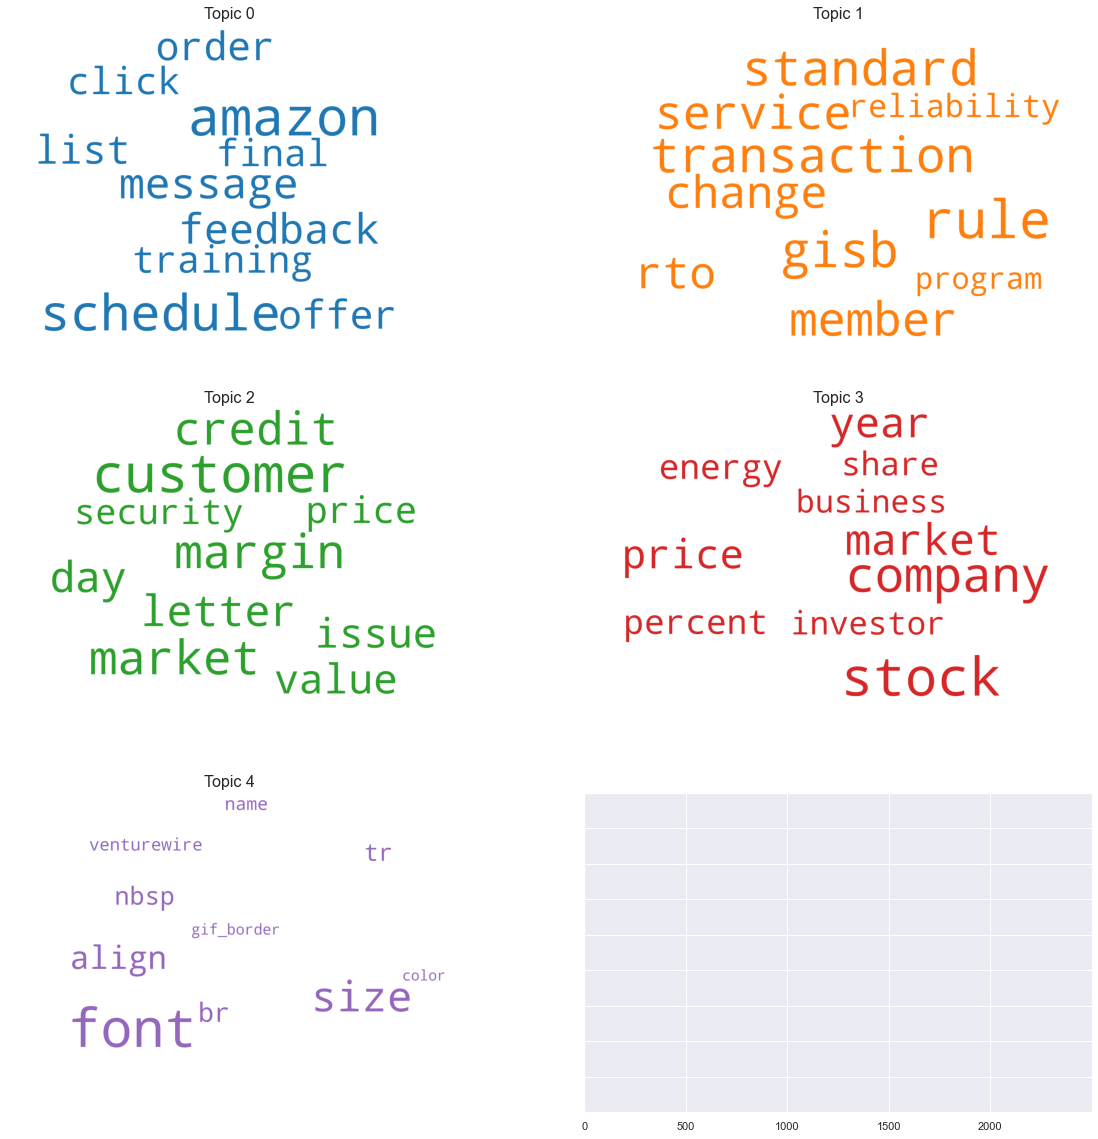

In [92]:


cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(3, 2, figsize=(20,20), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

### VIZ

In [85]:

pyLDAvis.enable_notebook()
LDAvis_data_filepath = os.path.join('./results/ldavis_prepared_'+str(f"test"))

if 1 == 1:
    LDAvis_prepared = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
    with open(LDAvis_data_filepath, 'wb') as f:
        pickle.dump(LDAvis_prepared, f)

with open(LDAvis_data_filepath, 'rb') as f:
    LDAvis_prepared = pickle.load(f)

pyLDAvis.save_html(LDAvis_prepared, './results/ldavis_prepared_'+ str(f"test") +'.html')
LDAvis_prepared

/Users/hsinhan/PycharmProjects/Enron_Email_Usecase/venv/lib/python3.9/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(
/Users/hsinhan/PycharmProjects/Enron_Email_Usecase/venv/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/hsinhan/PycharmProjects/Enron_Email_Usecase/venv/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/hsinhan/PycharmProjects/Enron_Email_Usecase/venv/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; se

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.058755  0.011310       1        1  45.706888
4      0.263836 -0.026494       2        1  20.281014
2     -0.107273 -0.142271       3        1  19.154735
1     -0.051865  0.063012       4        1   8.665176
0     -0.045943  0.094443       5        1   6.192187, topic_info=       Term        Freq       Total Category  logprob  loglift
49     font  415.000000  415.000000  Default  30.0000  30.0000
121    size  243.000000  243.000000  Default  29.0000  29.0000
5     align  130.000000  130.000000  Default  28.0000  28.0000
12       br   84.000000   84.000000  Default  27.0000  27.0000
80     nbsp   74.000000   74.000000  Default  26.0000  26.0000
..      ...         ...         ...      ...      ...      ...
656    cost    3.604576   38.097856   Topic5  -5.6222   0.4239
403   today    3.023167   15.248240   Topic5  -5.7981   1.1637
258    give    3.140309   23.189860   Topic5  -5.7601   0.7825
610  review    3.023169   25.365695   Topic5  -5.7981   0.6548
35     date    3.023170   29.118425   Topic5  -5.7981   0.5168

[325 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
1110      1  0.228593   accept
1110      3  0.457185   accept
1110      4  0.304790   accept
273       1  0.218739  account
273       2  0.249987  account
...     ...       ...      ...
225       1  0.834440     year
225       2  0.065191     year
225       3  0.065191     year
225       4  0.013038     year
225       5  0.013038     year

[594 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 5, 3, 2, 1])